This notebook explores the Mexico data following essentially the same steps as for the DMV poultry and NC pigs data (exploreUSAData notebook). The final output is a file containing farm and not-farm buildings.

In [1]:
try:
  import unidecode
except ModuleNotFoundError:
  !pip install pyogrio==0.7.2 geopandas==0.14.3 unidecode

In [2]:
%load_ext autoreload
%autoreload 2

import sys, os
from IPython.core.magic import register_cell_magic
from glob import glob
import numpy as np
from unidecode import unidecode
from google.colab import drive
import ee
import geemap.foliumap as geemap
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import pyproj
import pyarrow

gpd.options.io_engine = "pyogrio"
os.environ["PYOGRIO_USE_ARROW"] = "1"

In [3]:
ee.Authenticate()
ee.Initialize(project="215656163750")
drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/Colab Notebooks/')
import utils, explore

@register_cell_magic
def skip(line, cell):
    return

path = "/content/drive/MyDrive/CAFO_data/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Mexican states are divided into municipalities. There doesn't seem to be any further subdivision. So, while for Chile we had Region > Provincia > Comuna, for Mexico we have State > Municipio. They vary enormously in size.

In [4]:
# Define the farm types we are interested in, and translate to English for ease
# of labelling plots etc.

farm_types = {'Granjas pollo ': 'Broiler', 'Granjas huevo': 'Layer',\
               'Granjas porcinos': 'Pig', 'Establos lecheros': 'Dairy'}

In [5]:
# Read the Mexico farm data

df_dict = pd.read_excel(
      f"{path}Mexico/Infraestructura pecuaria 2021.xlsx",
      sheet_name=None,
      header=3
      )

# Print some info about farm types
print("The government records contain these farm types:")
print([item[0] for item in df_dict.items()])
print(f"We will look at {farm_types.keys()}")

The government records contain these farm types:
['Granjas pollo ', 'Granjas porcinos', 'Granjas huevo', 'Corrales de Engorda', 'Establos lecheros', 'Unidades ovinas', 'Centro de Sacrificio']
We will look at dict_keys(['Granjas pollo ', 'Granjas huevo', 'Granjas porcinos', 'Establos lecheros'])


In [6]:
# Edit the df so it's easier to work with, and print a little info about the
# data.

all_farms = gpd.GeoDataFrame()
for farm_type, df in df_dict.items():

  if farm_type in farm_types.keys():

    df.drop(columns=['Nombre del Municipio', 'Nombre del Estado'], inplace=True)

    # Create geodataframe with columns for fam trypes and animal numbers
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(
                                           df["Coordenada geográfica X"],
                                           df["Coordenada geográfica Y"]),\
                                           crs="EPSG:4326").drop(columns=\
                                           ["Clave Estado", "Clave Municipio",\
                                            "Coordenada geográfica X",\
                                            "Coordenada geográfica Y", "Estatus"])
    gdf.loc[:, "Farm type"] = farm_types[farm_type]
    gdf.loc[:, "N. animals"] = np.nan

    print(f"\n There are {len(gdf)} {farm_type}")

    # Concatenate into an overall gdf containing all farms
    all_farms = pd.concat([all_farms, gdf])

print(f"There are {len(all_farms)} registered farms in total ")


 There are 1592 Granjas pollo 


,geometry,Farm type,N. animals
0,POINT (-102.37036 21.89921),Broiler,NaN
1,POINT (-102.32942 21.75609),Broiler,NaN



 There are 2646 Granjas porcinos


,geometry,Farm type,N. animals
0,POINT (-102.41746 21.90085),Pig,NaN
1,POINT (-102.45316 21.73136),Pig,NaN



 There are 844 Granjas huevo


,geometry,Farm type,N. animals
0,POINT (-102.28030 21.76210),Layer,NaN
1,POINT (-102.28683 21.94014),Layer,NaN



 There are 3100 Establos lecheros


,geometry,Farm type,N. animals
0,POINT (-102.32838 21.82643),Dairy,NaN
1,POINT (-102.34626 21.82901),Dairy,NaN


There are 8182 registered farms in total 


In [7]:
# Read the admin district shapefiles. There are numerous municipios with the same name
# in different states, so we need to retain their parent states

munis = gpd.read_file(f'{path}Mexico/shapefiles/mex_admbnda_adm2_govmex_20210618.shp')
munis.crs="EPSG:4326"
munis = munis[['ADM2_ES', 'ADM1_ES', 'geometry']]
munis.rename(columns={'ADM2_ES':'Municipio', 'ADM1_ES':'Estado'}, inplace=True)

In [8]:
# Create a df containing just the comunas that contain farms, and just the farms
# that have coords within real comunas (some farms have coords outside the country)

# Find intersection of comunas and farms, retaining geometry of the parent farm
all_farms.loc[:, 'temp geom'] = all_farms.loc[:, 'geometry']
joined = munis.sjoin(all_farms, how='inner', predicate='intersects')

# Create df of comunas that contain farms
munis_w_farms = joined[~joined.index.duplicated(keep='first')]
munis_w_farms = munis_w_farms[munis.columns]
print(f"{len(munis_w_farms)} Municipios contain farms in the specified size range")

# Create a df in which all these comunas are represented by a single multipolygon
single_geom = munis_w_farms.drop(columns=["Municipio", "Estado"]).dissolve(by=None)

# Create df of farms with coords within Chilean comunas
mex_farms = joined[all_farms.columns].drop(columns=['geometry'])\
              .set_geometry('temp geom').rename(columns={"temp geom": "geometry"})

print(f"There are {len(mex_farms)} farms with coords within Mexican municipios")
for farm_type in farm_types.values():
  print(f" -- {len(mex_farms[mex_farms['Farm type'] == farm_type])} {farm_type} farms")


887 Municipios contain farms in the specified size range
There are 8180 farms with coords within Mexican municipios
 -- 2646 pig farms
 -- 2436 poultry farms
 -- 3098 dairy farms


The top 200 Municipio account for 6115/8180 farms (75%)


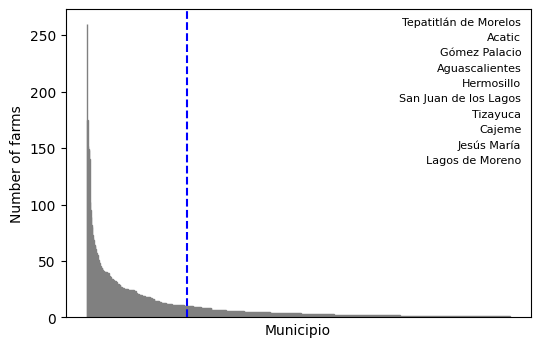

In [9]:
# Plot the distribution of farms by comuna

_, ax = plt.subplots(1, 1, figsize=(6, 4))
explore.farms_per_region(joined, ax, 200, 'Municipio')
plt.savefig('/content/drive/MyDrive/CAFO_data/Analysis/Mexico_farms_per_muni.png')

In [10]:
min_building_size = 400

In [11]:
%%skip
# Get buildings > min_building_size buildings and save for future use. This is
# time-consuming so don't run it unless there's a reason to recreate the file.

buildings_fc = (
      ee.FeatureCollection(f"projects/sat-io/open-datasets/VIDA_COMBINED/MEX")
      .filter(ee.Filter.gt('area_in_meters', min_building_size))
)

utils.write_to_file(buildings_fc, f"buildings_{min_building_size}_sq_m", 'Mexico')
utils.ee_task_status()

In [12]:
buildings = gpd.read_file(\
            f"/content/drive/MyDrive/CAFO_data/Mexico/buildings_{min_building_size}_sq_m.geojson")
buildings.rename(columns={"area_in_meters": "Area (sq m)"}, inplace=True)
print(f"There are {len(buildings)} buildings > {min_building_size} sq m in Mexico")

There are 1218374 buildings > 400 sq m in Mexico


In [13]:
# Filter the buildings dataset to just the Municipios that contain registered
# farms

farm_muni_bldgs = buildings.sjoin(single_geom, how='inner', predicate='within')
farm_muni_bldgs = farm_muni_bldgs.filter(["Area (sq m)", "geometry"])
print(f"There are {len(farm_muni_bldgs)} buildings > {min_building_size} sq m in\
 the municipios with registered farms")

There are 843663 buildings > 400 sq m in the municipios with registered farms


In [14]:
# Find all the buildings that are within <farm_dist> m of a farm, and those
# that are more than <not_farm_dist> away

crs = "EPSG:6372"
farm_dist = 150
not_farm_dist = 1000
farm_buildings, other_buildings = explore.join_farms_and_buildings(all_farms,\
                                                                  farm_muni_bldgs,\
                                                                  farm_dist,\
                                                                  not_farm_dist,\
                                                                  crs)

print(f"There are {len(farm_buildings)} buildings within {farm_dist} m of farm coords ")
print(f"There are {len(other_buildings)} buildings >{not_farm_dist} m from\
farm coords (any farm type) ")

There are 30953 buildings within 150 m of farm coords 
There are 720695 buildings >1000 m from farm coords 


In [15]:
new_total = 0
for farm_type in farm_types.values():
  n = len(all_farms[all_farms["Farm type"] == farm_type])
  print(f"Started with {n} farms of type {farm_type}")

  n = len(farm_buildings[farm_buildings["Farm type"] == farm_type].\
             groupby(by="Parent coords"))
  print(f" -- {n} are associated with buildings > {min_building_size} sq m")
  new_total += n

print(f"There is now a total of {new_total} farms")

Started with 1592 farms of type Broiler
 -- 1541 are associated with buildings > 400 sq m
Started with 844 farms of type Layer
 -- 816 are associated with buildings > 400 sq m
Started with 2646 farms of type Pig
 -- 1951 are associated with buildings > 400 sq m
Started with 3100 farms of type Dairy
 -- 1607 are associated with buildings > 400 sq m
There is now a total of 5915 farms


In [16]:
# Calculate the lengths and aspect ratios of those buildings

farm_buildings = explore.get_dimensions(farm_buildings, crs=crs)

In [17]:
# As we did for the NC pigs data (USA), we'll drop all but the largest building
# per farm

max_farm_bldgs = farm_buildings.sort_values('Area (sq m)', ascending=False)\
                              .drop_duplicates(['Parent coords'])
print(f"{len(farm_buildings)} buildings --> {len(max_farm_bldgs)} buildings")

30953 buildings --> 5857 buildings


In [18]:
# Obtain the comparison data (Delmarva poultry and NC pigs; see the exploreUSAData
# notebook)

dmv_data = pd.read_pickle("/content/drive/MyDrive/CAFO_data/Analysis/DMV_poultry_bldgs.pkl")
nc_data = pd.read_pickle("/content/drive/MyDrive/CAFO_data/Analysis/NC_pigs_bldgs.pkl")

Broiler


,Area (sq m),Length (m),Aspect ratio
Min,400.182007,26.181609,1.009664
Med,2143.545900,145.322935,8.903905
Max,40107.011000,368.747835,19.819729


Layer


,Area (sq m),Length (m),Aspect ratio
Min,468.783386,28.462414,1.008342
Med,2096.557460,125.623191,6.490407
Max,41931.722400,394.479957,21.414599


Pig


,Area (sq m),Length (m),Aspect ratio
Min,400.21701,21.035484,1.000860
Med,1122.21936,62.437229,3.183122
Max,45441.15625,324.491994,32.126462


Dairy


,Area (sq m),Length (m),Aspect ratio
Min,400.072113,20.868196,1.002083
Med,835.929871,52.979191,2.334637
Max,49591.858000,668.468505,46.472305


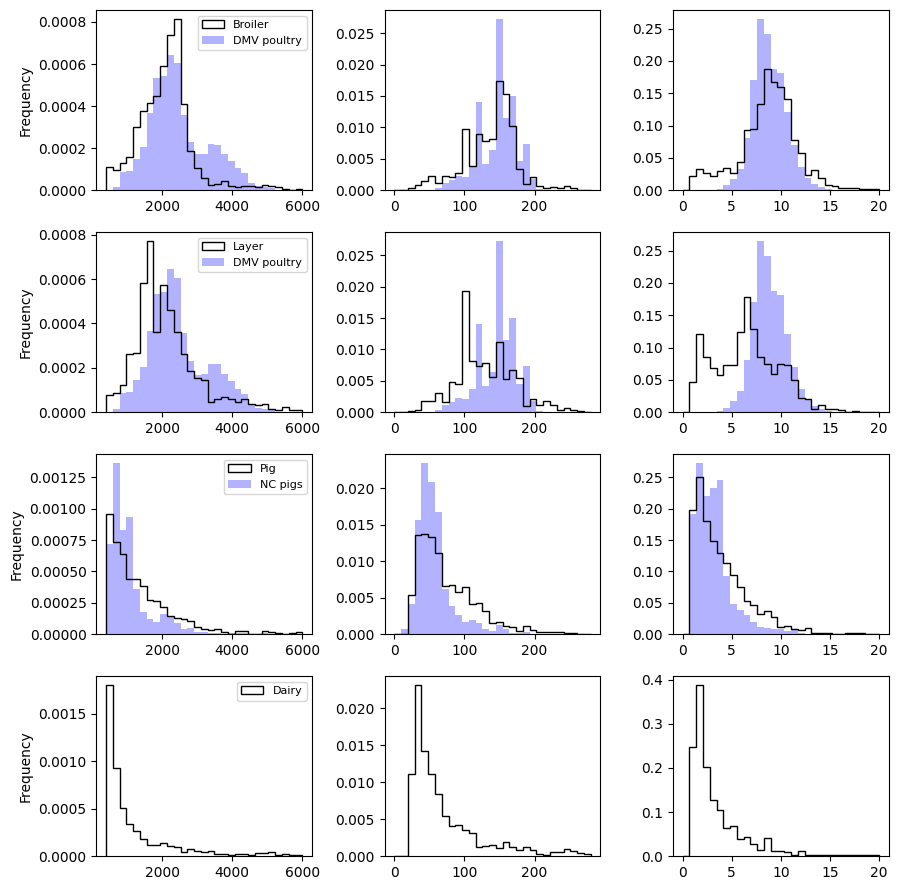

In [19]:
# Plot histograms showing all farm types, not-farms, and DMV+NC data

bins = {}
bins['Area (sq m)'] = np.linspace(min_building_size, 6000, 30)
bins['Length (m)'] = np.linspace(0, 280, 30)
bins['Aspect ratio'] = np.linspace(0, 20, 30)

_, axes = plt.subplots(4, 3, figsize=(9, 9))
for farm_type, ax in zip(farm_types.values(), axes):
  print(farm_type)
  to_plot = max_farm_bldgs[max_farm_bldgs["Farm type"] == farm_type]
  explore.histos(to_plot, ax, bins, farm_type, dmv_data, nc_data)

plt.tight_layout()
plt.savefig(f'/content/drive/MyDrive/CAFO_data/Analysis/Mexico_building_histos.png')

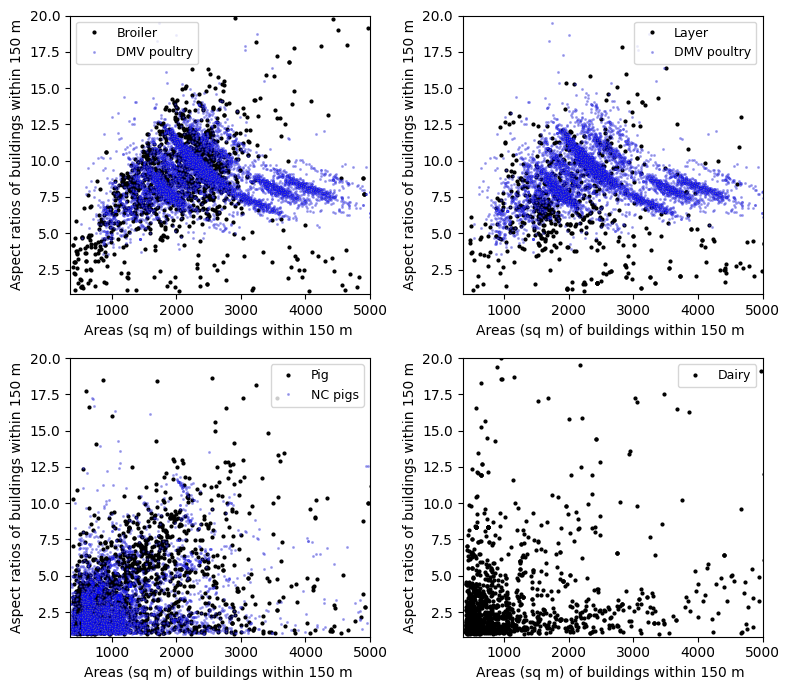

In [20]:
# Plot aspect ratio vs area for all farm types and DMV+NC data

_ , ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 7))

for ax, farm_type in zip([ax1, ax2, ax3, ax4], farm_types.values()):

  # Plot Mexico data
  to_plot = max_farm_bldgs[max_farm_bldgs["Farm type"] == farm_type]
  ax.plot(to_plot["Area (sq m)"], to_plot["Aspect ratio"], 'ko', ms=2,\
          label=farm_type)

  # Add comparison (DMV+NC) data
  if farm_type in ["Broiler", "Layer"]:
    ax.plot(dmv_data['Area (sq m)'], dmv_data['Aspect ratio'],\
               'bo', markerfacecolor=(1, 1, 0, 0.4), ms=1, label="DMV poultry")
  if farm_type == "Pig":
    ax.plot(nc_data['Area (sq m)'], nc_data['Aspect ratio'],\
               'bo', markerfacecolor=(1, 1, 0, 0.4), ms=1, label="NC pigs")

  ax.legend(fontsize=9)
  ax.set_xlim(min_building_size-50, 5000)
  ax.set_ylim(0.8, 20)
  ax.set_xlabel(f'Areas (sq m) of buildings within {farm_dist} m ')
  ax.set_ylabel(f'Aspect ratios of buildings within {farm_dist} m')

plt.tight_layout()
plt.savefig("/content/drive/MyDrive/CAFO_data/Analysis/Mexico_aspect_area.png")

In [21]:
# Now get a stratified sample of not-farm buildings, like we did for NC. But
# which building size distribution should we match? Probably the overall
# distribution for pigs, layers, and broilers (not dairy though).

to_sample = max_farm_bldgs[max_farm_bldgs['Farm type'].\
                           isin(["Broiler", "Layer", "Pig"])]
sampled = explore.stratified_sample(to_sample, other_buildings, 'Area (sq m)',\
                                 bins=bins['Area (sq m)'])

notfarm_buildings = explore.get_dimensions(sampled, crs=crs)

notfarm_buildings = notfarm_buildings[notfarm_buildings['Aspect ratio'] < 20]

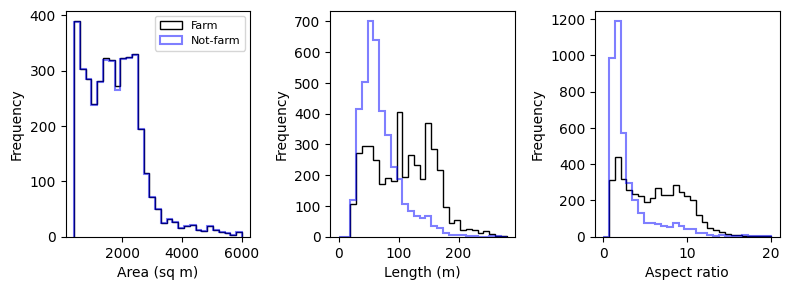

<Figure size 640x480 with 0 Axes>

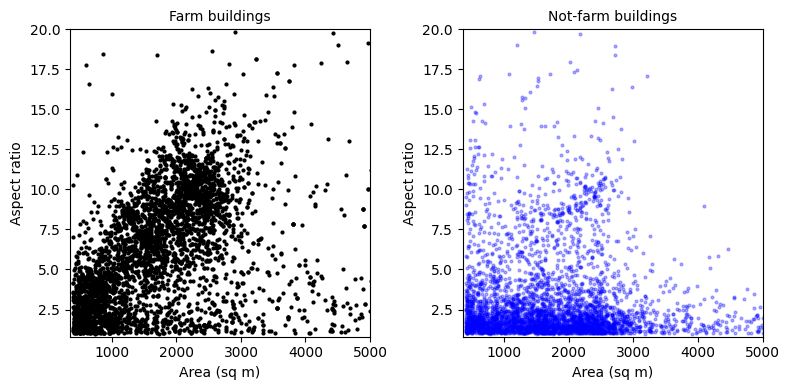

<Figure size 640x480 with 0 Axes>

In [24]:
# Plot histograms of all farm buildings (except dairy) and all not-farm buildings
# Also aspect vs area plots

_, axes = plt.subplots(1, 3, figsize=(8, 3))

for ax, col in zip(axes, ["Area (sq m)", "Length (m)", "Aspect ratio"]):
  ax.hist(to_sample[col], bins=bins[col], histtype='step', color='k',\
          label="Farm")
  ax.hist(notfarm_buildings[col], bins=bins[col], histtype='step', color='b',\
          alpha=0.5, lw=1.5, label="Not-farm")
  if col == "Area (sq m)":
    ax.legend(fontsize=8)
  ax.set_ylabel("Frequency")
  ax.set_xlabel(col)
plt.tight_layout()
plt.show()
plt.savefig("/content/drive/MyDrive/CAFO_data/Analysis/Mexico_final_histos.png")

def axis_stuff(ax, label):
  ax.set_xlim(min_building_size-50, 5000)
  ax.set_ylim(0.8, 20)
  ax.set_xlabel(f'Area (sq m)')
  ax.set_ylabel(f'Aspect ratio')
  ax.set_title(label, fontsize=10)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.plot(to_sample["Area (sq m)"], to_sample["Aspect ratio"], 'ko', ms=2)
axis_stuff(ax1, "Farm buildings")
ax2.plot(notfarm_buildings["Area (sq m)"], notfarm_buildings["Aspect ratio"],\
        'bo', ms=2, alpha=0.3)
axis_stuff(ax2, "Not-farm buildings")
plt.tight_layout()
plt.show()
plt.savefig("/content/drive/MyDrive/CAFO_data/Analysis/Mexico_final_aspect_area.png")

In [23]:

# -- Farm buildings
max_farm_bldgs.loc[:, "Dataset name"] = "Mexico"
max_farm_bldgs = explore.re_order(max_farm_bldgs)


# -- Not-farm buildings
coldict = {"Dataset name": "Mexico", "Parent coords": np.nan,\
           "Farm type": "Non-farm", "N. animals": np.nan}
for col, val in coldict.items():
  notfarm_buildings.loc[:, col] = val

notfarm_buildings = explore.re_order(notfarm_buildings)

mex = pd.concat([max_farm_bldgs, notfarm_buildings])
mex.to_pickle(f'/content/drive/MyDrive/CAFO_data/Analysis/Mexico_bldgs.pkl')

# The future warning arises because the dtypes of the Parent coords column differ
# between dfs (geometry vs float). Not sure what if anything to do about that.

<ipython-input-23-c62575a0cc86>:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mex = pd.concat([max_farm_bldgs, notfarm_buildings])
